In [209]:
import cv2 as cv
print("Current version of openCV=", cv.__version__)
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image, ImageDraw

Current version of openCV= 4.1.1


In [52]:
left_calibration_path = './calibration/fisheye_calibrated/{}.png'
right_calibration_path ='./calibration/pinhole_calibrated/{}.png'

In [53]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
points_per_row = 6
points_per_column = 10
objp = np.zeros((points_per_column*points_per_row,3), np.float32)
objp[:,:2] = np.mgrid[0:points_per_row,0:points_per_column].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in Right image plane.
imgpointsR = [] # 2d points in Left image plane.
imagesL = glob.glob(left_calibration_path.format('*'))
imagesR = glob.glob(right_calibration_path.format('*'))
for img_id in range(len(imagesR)):
    fnameL = left_calibration_path.format(img_id)
    fnameR = right_calibration_path.format(img_id)
    imgL = cv.imread(fnameL)
    imgR = cv.imread(fnameR)
    grayL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
    grayR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    retL, cornersL = cv.findChessboardCorners(grayL, (points_per_row,points_per_column), None)
    retR, cornersR = cv.findChessboardCorners(grayR, (points_per_row,points_per_column), None)
    # If found on both, add object points, image points (after refining them)
    if retL == True and retR == True:
        objpoints.append(objp)
        corners2L = cv.cornerSubPix(grayL,cornersL, (11,11), (-1,-1), criteria)
        corners2R = cv.cornerSubPix(grayR,cornersR, (11,11), (-1,-1), criteria)
        imgpointsL.append(cornersL)
        imgpointsR.append(cornersR)
        # Draw and display the corners
        cv.drawChessboardCorners(imgL, (points_per_row,points_per_column), corners2L, retL)
        cv.drawChessboardCorners(imgR, (points_per_row,points_per_column), corners2R, retR)
        cv.imshow('img', imgL)
        cv.waitKey(500)
        cv.imshow('img', imgR)
        cv.waitKey(500)
cv.destroyAllWindows()

In [283]:
img = cv.imread(left_calibration_path.format(img_id))
width, height = img.shape[:-1]
R = None
T = None
E = None
F = None
# Try loading previous calibration matrices. else recompute
cameraMatrix1 = None
distCoeffs1 = None
cameraMatrix2 = None
distCoeffs2 = None

stereocalib_criteria = (cv.TERM_CRITERIA_MAX_ITER | cv.TERM_CRITERIA_EPS, 100, 1e-5)
#This flag decreases the accuracy but now the results match better... it is probably better for the 3d reconstruct to be on
stereocalib_flags = cv.CALIB_RATIONAL_MODEL | \
cv.CALIB_SAME_FOCAL_LENGTH
#cv.CALIB_ZERO_DISPARITY
#cv.CALIB_FIX_K3 | \
#cv.CALIB_FIX_K4
#cv.CALIB_ZERO_TANGENT_DIST #
#cv.CALIB_FIX_ASPECT_RATIO 
#cv.CALIB_FIX_K3 | \
#cv.CALIB_FIX_K4 | \
#cv.CALIB_FIX_K5 
print(width, height)
retval, KL, DL, KR, DR, R, T, E, F = \
 cv.stereoCalibrate(objpoints, imgpointsL, imgpointsR,
                                #imageSize = (width, height),
                                imageSize = (height, width),
                                cameraMatrix1 = cameraMatrix1,
                                distCoeffs1 = distCoeffs1,
                                cameraMatrix2 = cameraMatrix2,
                                distCoeffs2 = distCoeffs2,
                                R=R,
                                T=T,
                                E=E,
                                F=F,
                                #flags=cv.CALIB_FIX_INTRINSIC
                                flags=stereocalib_flags,
                                criteria=stereocalib_criteria
                   )

720 1280


In [284]:
print(retval)
print("cameraM1: \n", KL)
print("distCoeffs1: \n", DL)
print("cameraM2: \n", KR)
print("distCoeffs2: \n", DR)
print("R: ", R)
print("T: ", T)
print("E: ", E)
print("F: ", F)

3.1961377234854718
cameraM1: 
 [[802.11721732   0.         623.22087234]
 [  0.         811.59053067 333.30576496]
 [  0.           0.           1.        ]]
distCoeffs1: 
 [[-7.03114181e+00  1.49422684e+01  7.93620777e-03  7.08637333e-03
  -8.28869175e+00 -7.03898126e+00  1.49989650e+01 -8.38848878e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
cameraM2: 
 [[802.11721732   0.         637.98681702]
 [  0.         811.59053067 349.28613959]
 [  0.           0.           1.        ]]
distCoeffs2: 
 [[ 1.09285318e+02  4.84849538e+02  3.46575944e-03 -6.17171589e-03
   4.11781408e+02  7.53613839e+01  4.39702201e+02  1.80059334e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
R:  [[ 0.99968986 -0.00218367  0.02480762]
 [ 0.00190046  0.99993282  0.01143429]
 [-0.02483092 -0.0113836   0.99962685]]
T:  [[ 3.67232582]
 [-0.25571715]
 [-1.08089799]]
E:  [[ 0.00840389  1.08373636 -0.

In [285]:
img_size = imgL.shape[:2]
alpha = 0 ### =0 crop, =1 keep dimensions
print(width, height)

RL = np.zeros(shape=(3,3))
RR = np.zeros(shape=(3,3))
PL = np.zeros(shape=(3,4))
PR = np.zeros(shape=(3,4))

"""out = cv.stereoRectify(KL, DL, KR, DR, (width, height), R=R, T=T, 
                       R1=RL, R2=RR, P1=PL, P2=PR,
                      Q=None, flags=cv.CALIB_ZERO_DISPARITY, alpha=alpha, newImageSize=(0,0))
"""
RL, RR, PL, PR, Q, roiL, roiR = cv.stereoRectify(KL, 
                                                 DL, 
                                                 KR, 
                                                 DR, 
                                                 (height, width), 
                                                 R=R, 
                                                 T=T, 
                                                 alpha=alpha)

720 1280


In [286]:
print("RL: \n", RL)
print("RR: \n", RR)
print("PL: \n", PL)
print("RR: \n", PR)
print("Q: ", Q)
print("roiL: \n", roiL)
print("roiR: \n", roiR)


RL: 
 [[ 0.96374767 -0.06553011 -0.25864304]
 [ 0.06714765  0.9977397  -0.00258506]
 [ 0.25822783 -0.01487593  0.96596951]]
RR: 
 [[ 0.95717556 -0.06665155 -0.2817313 ]
 [ 0.06488396  0.99777073 -0.0156093 ]
 [ 0.28214363 -0.00333901  0.95936637]]
PL: 
 [[1.34862688e+03 0.00000000e+00 9.83503563e+02 0.00000000e+00]
 [0.00000000e+00 1.34862688e+03 3.60555145e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
RR: 
 [[1.34862688e+03 0.00000000e+00 9.83503563e+02 5.17417865e+03]
 [0.00000000e+00 1.34862688e+03 3.60555145e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
Q:  [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -9.83503563e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -3.60555145e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.34862688e+03]
 [ 0.00000000e+00  0.00000000e+00 -2.60645597e-01  0.00000000e+00]]
roiL: 
 (0, 0, 1280, 720)
roiR: 
 (0, 0, 1280, 720)


In [287]:
# load camera and distortion matrices
path_to_matrices = "./calibration_matrices/"
cameraMatrix1 = np.load(path_to_matrices+"fisheye_new_matrix.npy")
distCoeffs1 = np.load(path_to_matrices+"fisheye_distortions.npy")
cameraMatrix2 = np.load(path_to_matrices+"pinhole_new_matrix.npy")
distCoeffs2 = np.load(path_to_matrices+"pinhole_distortions.npy")
print("cameraMatrix1: \n", cameraMatrix1)
print("distCoeffs1: \n", distCoeffs1)
print("cameraMatrix2: \n", cameraMatrix2)
print("distCoeffs2: \n", distCoeffs2)

cameraMatrix1: 
 [[770.27392578   0.         604.03858401]
 [  0.         773.95489502 321.97347741]
 [  0.           0.           1.        ]]
distCoeffs1: 
 [[-7.63157450e-01 -2.28545804e+01 -2.01766132e-02 -4.91723979e-03
   4.95143851e+01 -6.73908321e-01 -2.34229292e+01  5.04215253e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
cameraMatrix2: 
 [[1.09387634e+03 0.00000000e+00 6.47218680e+02]
 [0.00000000e+00 1.09678967e+03 3.55147063e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distCoeffs2: 
 [[ 0.02451276  0.04372337 -0.00407773  0.0011938  -0.12879966]]


In [288]:
def undistort_and_crop(img, camera_matrix, distortion_coeffs):
    h,  w = img.shape[:2]
    alpha = 0 #crop image
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(camera_matrix, distortion_coeffs, (w,h), alpha, (w,h))
    # undistort
    dst = cv.undistort(img, camera_matrix, distortion_coeffs, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

In [290]:
print("Applying Undistort\n")
#map1x, map1y = cv.initUndistortRectifyMap(KL, DL, RL, PL, (width, height), cv.CV_32FC1)
#map2x, map2y = cv.initUndistortRectifyMap(KR, DR, RR, PR, (width, height), cv.CV_32FC1)

map1x, map1y = cv.initUndistortRectifyMap(KL, DL, RL, PL, (height, width), cv.CV_32FC1)
map2x, map2y = cv.initUndistortRectifyMap(KR, DR, RR, PR, (height, width), cv.CV_32FC1)
print("Undistort complete\n")

#print("Maps1: \n", map1x, map1y)
#print("Maps2: \n", map2x, map2y)

#image remap example
img_id = 1
validation_path = './validation_images/'
pinhole_path = 'pinhole/{}.png'
fisheye_path = 'fisheye/{}.png'
fnameL = validation_path+fisheye_path.format(img_id)
fnameR = validation_path+pinhole_path.format(img_id)
print("fname: ", fnameL, fnameR)
imgL = cv.imread(fnameL)
imgR = cv.imread(fnameR)
cv.imshow("imgL original: ", imgL)
cv.imshow("imgR original: ", imgR)
imgL = undistort_and_crop(imgL, cameraMatrix1, distCoeffs1)
imgR = undistort_and_crop(imgR, cameraMatrix2, distCoeffs2)
cv.imshow('imgL', imgL)
cv.imshow('imgr', imgR)
if cv.waitKey(500) & 0xff == 27:
    cv.destroyAllWindows()

left_img_remap = cv.remap(imgL, map1x, map1y, cv.INTER_LANCZOS4)
right_img_remap = cv.remap(imgR, map2x, map2y, cv.INTER_LANCZOS4)

Applying Undistort

Undistort complete

fname:  ./validation_images/fisheye/1.png ./validation_images/pinhole/1.png


In [294]:
cv.imshow("imgL remap", left_img_remap)
cv.imshow("imgR remap", right_img_remap)
left_gray_remap = cv.cvtColor(left_img_remap, cv.COLOR_BGR2GRAY)
right_gray_remap = cv.cvtColor(right_img_remap, cv.COLOR_BGR2GRAY)
if cv.waitKey(500) & 0xff == 27:
    cv.destroyAllWindows()

## Stereo reconstruction

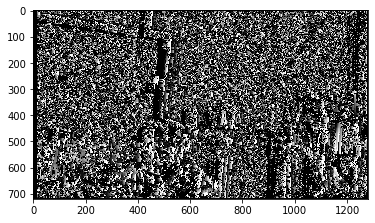

In [264]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=5)
disparity = stereo.compute(left_gray_remap, right_gray_remap)
plt.imshow(disparity,'gray')
plt.show()

## Finding corners with Harris algorithm

In [139]:
left_gray_remap = cv.cvtColor(left_img_remap, cv.COLOR_BGR2GRAY)
right_gray_remap = cv.cvtColor(right_img_remap, cv.COLOR_BGR2GRAY)
left_kpts = cv.cornerHarris(left_gray_remap, 2, 3, 0.04)

In [277]:
#left_kpts = cv.dilate(left_kpts, None)
left_img_copy = left_img_remap
left_img_copy[left_kpts > 0.01*left_kpts.max()] = [0,0,255]
cv.imshow('with corners',left_img_copy)
if cv.waitKey(0) & 0xff == 27:
    cv.destroyAllWindows()

## Use SURF for feature extraction

In [295]:
#-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
minHessian = 400
detector = cv.xfeatures2d_SURF.create(hessianThreshold=minHessian)
keypoints1, descriptors1 = detector.detectAndCompute(left_gray_remap, None)
keypoints2, descriptors2 = detector.detectAndCompute(right_gray_remap, None)
#-- Step 2: Matching descriptor vectors with a FLANN based matcher
# Since SURF is a floating-point descriptor NORM_L2 is used
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2)
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.5 #maybe decrease it? originally set to 0.7
good_matches = []
for m,n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
#-- Draw matches
img_matches = np.empty((max(left_gray_remap.shape[0], right_gray_remap.shape[0]), 
                        left_gray_remap.shape[1]+right_gray_remap.shape[1], 3), dtype=np.uint8)
cv.drawMatches(left_gray_remap, keypoints1, right_gray_remap, 
               keypoints2, good_matches, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#-- Show detected matches
cv.imshow('Good Matches', img_matches)
if cv.waitKey(500) & 0xff == 27:
    cv.destroyAllWindows()

In [296]:
#cv.destroyAllWindows()
triangulation_constant = 800 * 0.18
depths = np.zeros(len(good_matches))
for idx in range(len(good_matches)):
    m = good_matches[idx]
    left_pt = keypoints1[m.queryIdx].pt
    right_pt = keypoints2[m.trainIdx].pt
    dispartity = abs(left_pt[0] - right_pt[0])
    z = triangulation_constant / dispartity
    depths[idx] = z
    print("m.queryIdx: ", m.queryIdx)
    print("distance: ", z)


m.queryIdx:  3
distance:  2.732152907252788
m.queryIdx:  9
distance:  11.412368216744909
m.queryIdx:  56
distance:  3.0524255264094187
m.queryIdx:  62
distance:  3.8792980979190235
m.queryIdx:  66
distance:  3.8564325200806824
m.queryIdx:  68
distance:  3.046698124171916
m.queryIdx:  71
distance:  3.038340879939421
m.queryIdx:  81
distance:  3.892482627087884
m.queryIdx:  82
distance:  3.4750465809920095
m.queryIdx:  87
distance:  3.8112296821842926
m.queryIdx:  95
distance:  3.3794411372061446
m.queryIdx:  96
distance:  3.0628234936732524
m.queryIdx:  102
distance:  2.570484430309825
m.queryIdx:  104
distance:  0.6759176601228245
m.queryIdx:  111
distance:  2.9693225281509066
m.queryIdx:  114
distance:  0.6759875730162656
m.queryIdx:  116
distance:  3.029932075878782
m.queryIdx:  118
distance:  2.545903056319015
m.queryIdx:  119
distance:  2.5550484845990735
m.queryIdx:  120
distance:  2.59777427634252
m.queryIdx:  130
distance:  4.032012796915615
m.queryIdx:  134
distance:  2.9624249

In [298]:
#Convert openCV BGR image top PIL RGB format

pil_img = cv.cvtColor(left_img_remap, cv.COLOR_BGR2RGB)
pil_img = Image.fromarray(pil_img)
draw_depths = ImageDraw.Draw(pil_img)
for d_match, depth in zip(good_matches, depths):
    print('dmatch: ', d_match)
    print("depth: ", depth)
    draw_depths.text(keypoints1[d_match.queryIdx].pt, str(depth), fill=(255,255,255))#white text

pil_img.show()

dmatch:  <DMatch 0x7fa3b404e930>
depth:  2.732152907252788
dmatch:  <DMatch 0x7fa3b404e190>
depth:  11.412368216744909
dmatch:  <DMatch 0x7fa3b411dbf0>
depth:  3.0524255264094187
dmatch:  <DMatch 0x7fa3b411dc30>
depth:  3.8792980979190235
dmatch:  <DMatch 0x7fa3a6f532f0>
depth:  3.8564325200806824
dmatch:  <DMatch 0x7fa3a6f53a10>
depth:  3.046698124171916
dmatch:  <DMatch 0x7fa3a6f53950>
depth:  3.038340879939421
dmatch:  <DMatch 0x7fa3a6f53990>
depth:  3.892482627087884
dmatch:  <DMatch 0x7fa3a6f53d90>
depth:  3.4750465809920095
dmatch:  <DMatch 0x7fa3a6f53b10>
depth:  3.8112296821842926
dmatch:  <DMatch 0x7fa3a6f53510>
depth:  3.3794411372061446
dmatch:  <DMatch 0x7fa3a6f533b0>
depth:  3.0628234936732524
dmatch:  <DMatch 0x7fa3a6f53490>
depth:  2.570484430309825
dmatch:  <DMatch 0x7fa3a6f53e90>
depth:  0.6759176601228245
dmatch:  <DMatch 0x7fa3a6f53870>
depth:  2.9693225281509066
dmatch:  <DMatch 0x7fa3b40582b0>
depth:  0.6759875730162656
dmatch:  <DMatch 0x7fa3b40589f0>
depth:  3.02

In [299]:
cv.destroyAllWindows()